In [47]:
import networkx as nx
import random
from matplotlib import pyplot as plt
from functools import wraps
import time
import pandas as pd
import os
import seaborn as sns

In [24]:
df = pd.DataFrame(columns=["time", "nodes", "edges", "best_w",  "iterations", "tabu size"])

In [25]:
def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result1, result2 = func(*args, **kwargs)
        end = time.perf_counter()
        elapsed = end - start
        print(f"{func.__name__} took {elapsed:.6f} seconds")
        return (result1, result2, elapsed)
    return wrapper

In [26]:
def initialize(G, terminals):
    subgraph = G.subgraph(terminals)
    
    if not nx.is_connected(subgraph):
        H = nx.Graph()
    
        for u in terminals:
            for v in terminals:
                if u != v:
                    path = nx.shortest_path(G, u, v, weight="weight")
                    nx.add_path(H, path)
        subgraph = H
    
    best_tree = nx.minimum_spanning_tree(subgraph, weight="weight")
    best_w = best_tree.size(weight="weight")
    best_nodes = set(best_tree.nodes())

    return best_tree, best_w, best_nodes


In [27]:
@timeit
def tabu_search(G, terminals, iterations, tabu_size):
    current_tree, current_w, current_nodes = initialize(G, terminals)
    best_tree, best_w, best_nodes = current_tree, current_w, current_nodes
    
    nodes = list(set(G.nodes()) - set(terminals))
    tabu_list = []

    for _ in range(iterations):
        neighborhood = []
        
        for v in nodes:
            new_nodes = current_nodes | {v}
            subgraph = G.subgraph(new_nodes)
            if nx.is_connected(subgraph):
                T = nx.minimum_spanning_tree(subgraph, weight = "weight")
                w = T.size(weight = "weight")
                neighborhood.append((T, w, new_nodes, ("add", v)))

        for v in current_nodes - set(terminals):
            new_nodes = current_nodes - {v}
            subgraph = G.subgraph(new_nodes)
            if nx.is_connected(subgraph):
                T = nx.minimum_spanning_tree(subgraph, weight = "weight")
                w = T.size(weight = "weight")
                neighborhood.append((T, w, new_nodes, ("remove", v)))

        neighborhood = [n for n in neighborhood if n[3] not in tabu_list]
        if len(neighborhood) == 0:
            break

        candidate = min(neighborhood, key = lambda x: x[1])
        current_tree, current_w, current_nodes, move = candidate

        tabu_list.append(move)
        if len(tabu_list) > tabu_size:
            tabu_list.pop(0)

        if current_w < best_w:
            best_tree, best_w, best_nodes = current_tree, current_w, current_nodes

    return best_tree, best_w

In [24]:
K5 = nx.Graph()
edgesK5 = [
    (0, 1, 28), (0, 2, 13), (0, 3, 13), (0, 4, 22),
    (1, 2, 27), (1, 3, 28), (1, 4, 13),
    (2, 3, 19), (2, 4, 14),
    (3, 4, 19)
]
K5.add_weighted_edges_from(edgesK5)

In [25]:
K5best = nx.Graph()
edgesK5best = [
    (0, 1, 18), (0, 2, 20), (0, 3, 22), (0, 5, 10), (0, 6, 32), (0, 7, 29),
    (1, 2, 12), (1, 3, 18), (1, 4, 20), (1, 5, 29), (1, 6, 36), (1, 7, 10),
    (2, 3, 40), (2, 4, 20), (2, 5, 22), (2, 6, 21), (2, 7, 23),
    (3, 4, 22), (3, 5, 22), (3, 6, 40), (3, 7, 22),
    (4, 5, 23), (4, 6, 32), (4, 7, 20),
    (5, 6, 21), (5, 7, 33),
    (6, 7, 11)
]
K5best.add_weighted_edges_from(edgesK5best)

In [26]:
CS4234_2 = nx.Graph()
edgesCS4234_2 = [
    (0, 1, 14), (0, 3, 14), (0, 6, 8),
    (1, 2, 14), (1, 6, 14),
    (2, 3, 14), (2, 4, 10), (2, 5, 8),
    (3, 5, 8),
    (4, 2, 10),
    (5, 6, 6),
    (6, 0, 8)
]
CS4234_2.add_weighted_edges_from(edgesCS4234_2)

tabu_search took 0.006160 seconds


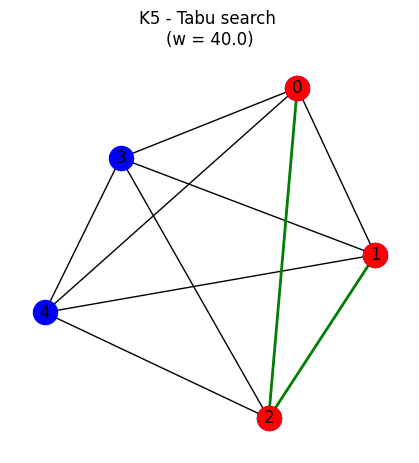

tabu_search took 0.077309 seconds


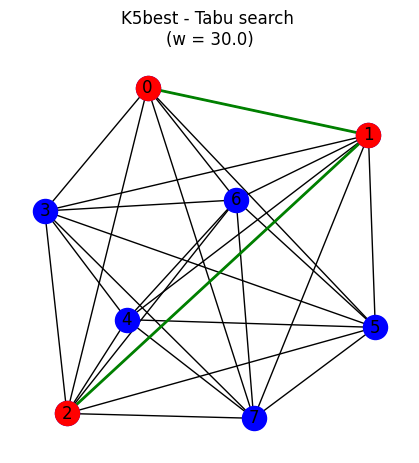

tabu_search took 0.052969 seconds


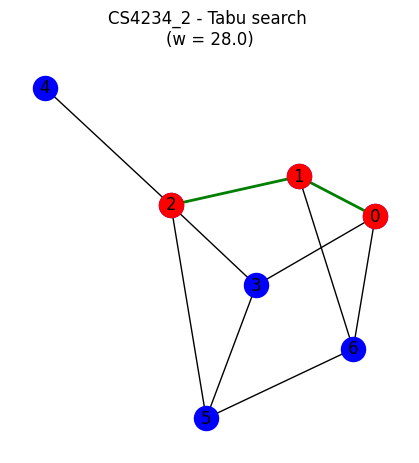

In [50]:
GS = [K5, K5best, CS4234_2]
names = ["K5", "K5best", "CS4234_2"]
terminals = [0,1,2]
for G, name in zip(GS, names): 
    pos = nx.spring_layout(G, seed = 42)
    T, w = tabu_search(G, terminals, 100, 5)
    
    plt.figure(figsize = (4,4))
    nx.draw(G, pos, with_labels = True, node_color = 'blue')
    nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
    nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')
    
   # edge_labels = nx.get_edge_attributes(G, "weight") 
   # nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 8)  

    plt.title(f"{name} - Tabu search \n(w = {w})")
    plt.show()

In [28]:
def read_stp(filename):
    G = nx.Graph()
    terminals = set()
    
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('E'):
                parts = line.split()
                u, v, w = int(parts[1]), int(parts[2]), int(parts[3])
                G.add_edge(u, v, weight = w)
            elif line.startswith('T'):
                terminals.add(int(line.split()[1]))
                
    return G, terminals

In [52]:
G, terminals = read_stp('hc6u.stp')

tabu_search took 4.296476 seconds


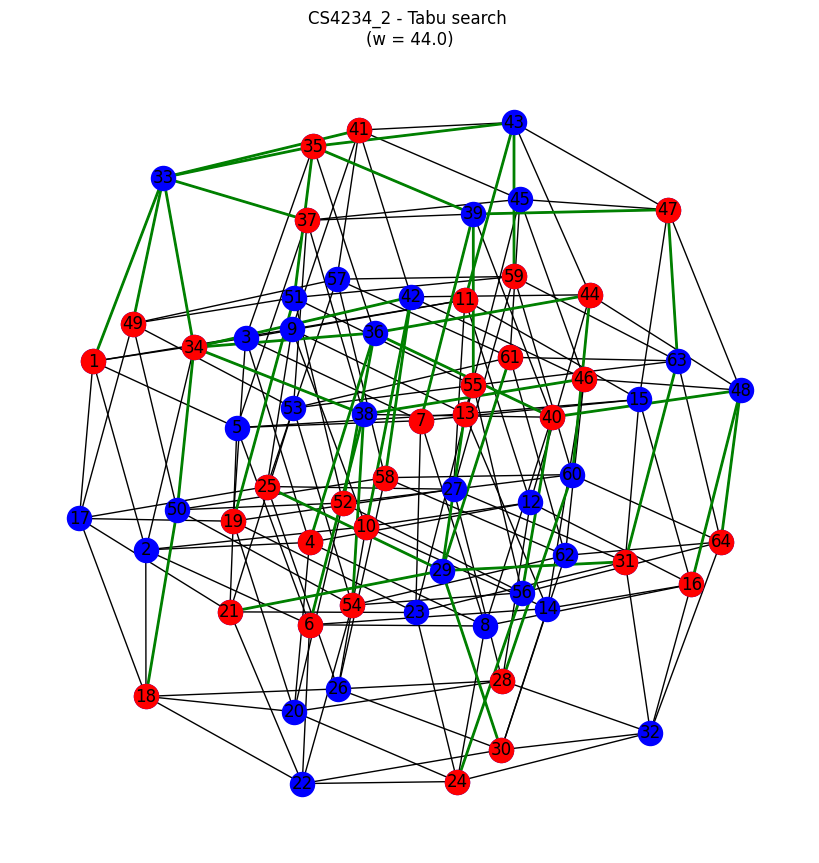

In [53]:
pos = nx.spring_layout(G, seed = 42)
T, w, _ = tabu_search(G, terminals, 100, 5)
    
plt.figure(figsize = (8,8))
nx.draw(G, pos, with_labels = True, node_color = 'blue')
nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')

plt.title(f"{name} - Tabu search \n(w = {w})")
plt.show()

tabu_search took 337.645058 seconds


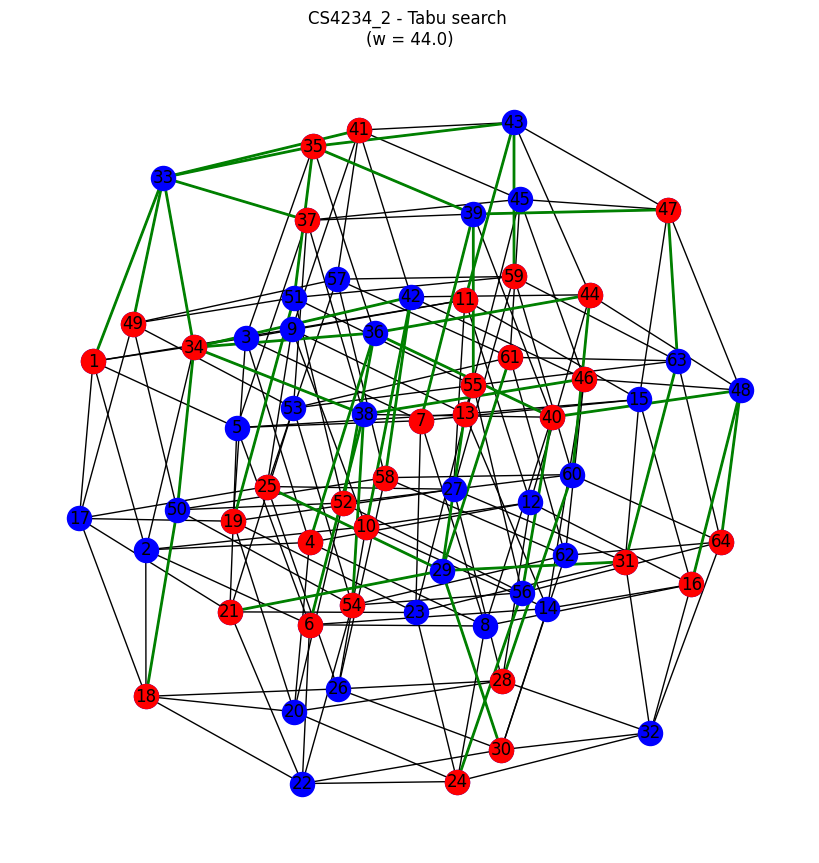

In [54]:
pos = nx.spring_layout(G, seed = 42)
T, w, _ = tabu_search(G, terminals, 10000, 5)
    
plt.figure(figsize = (8,8))
nx.draw(G, pos, with_labels = True, node_color = 'blue')
nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')

plt.title(f"{name} - Tabu search \n(w = {w})")
plt.show()

tabu_search took 2877.768951 seconds


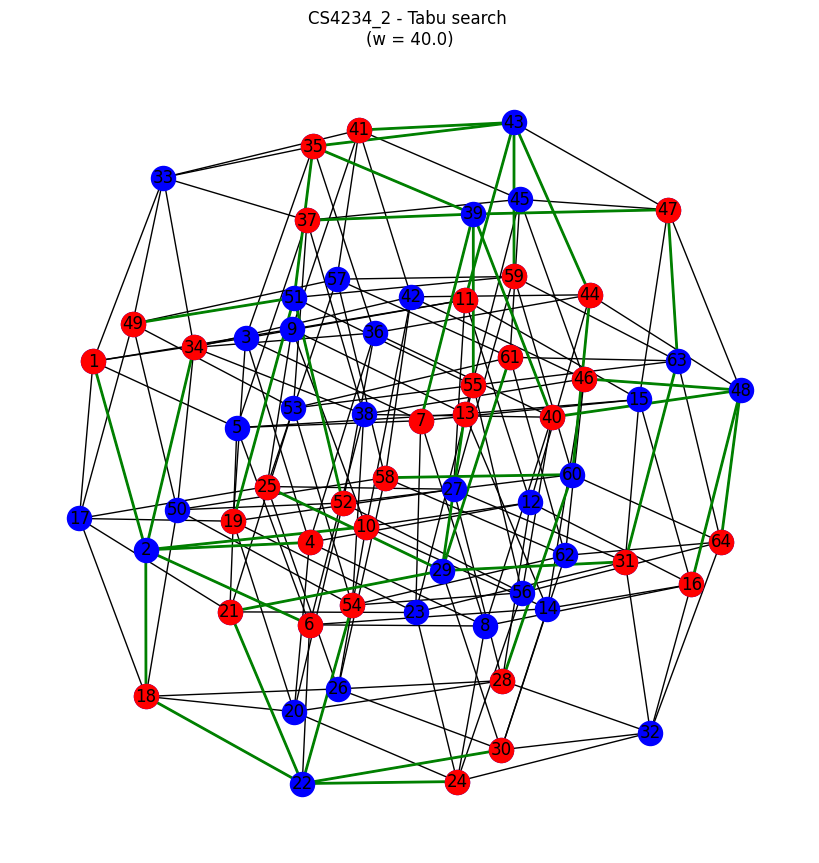

In [55]:
pos = nx.spring_layout(G, seed = 42)
T, w, _ = tabu_search(G, terminals, 100000, 30)
    
plt.figure(figsize = (8,8))
nx.draw(G, pos, with_labels = True, node_color = 'blue')
nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')

plt.title(f"{name} - Tabu search \n(w = {w})")
plt.show()

In [29]:
def tests(directory):
    global df
    df = df[0:0]
    results = {}
    
    for fname in os.listdir(directory):
        if fname.endswith(".stp"):
            path = os.path.join(directory, fname)
            try:
                G, terminals = read_stp(path) 
                results[fname] = (G, terminals)
                print(f"{fname} : (Number of nodes = {G.number_of_nodes()}, number of edges = {G.number_of_edges()}, number of terminals = {len(terminals)})")
                test_big(G, terminals)
            except Exception as e:
                print(f"File error {fname}: {e}")
        print("\n")
    return 

In [30]:
def test_big(G, terminals):
    global df
    num_iterations = [10,100,1000]
    tabu_sizes = [20,40,60,80]
    
    for iterations in num_iterations:
        for tabu_size in tabu_sizes:
            best_tree, best_w, elapsed = tabu_search(G, terminals, iterations, tabu_size)
            new_row = {
                    "time": round(elapsed, 6),
                    "nodes" : G.number_of_nodes(),
                    "edges" : G.number_of_edges(),
                    "best_w": best_w,
                    "iterations": iterations,
                    "tabu size" : tabu_size
                }
            df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

In [37]:
tests('../Big graphs')
df.to_csv('results_tabu.csv')
df

cc9-2u.stp : (Number of nodes = 512, number of edges = 2304, number of terminals = 64)
tabu_search took 108.539498 seconds
tabu_search took 105.641827 seconds
tabu_search took 105.434957 seconds
tabu_search took 106.718315 seconds
tabu_search took 899.834036 seconds
tabu_search took 953.423762 seconds
tabu_search took 983.379715 seconds
tabu_search took 987.372260 seconds
tabu_search took 2928.115863 seconds
tabu_search took 2889.660570 seconds
tabu_search took 2677.389265 seconds
tabu_search took 2509.686425 seconds


hc6u.stp : (Number of nodes = 64, number of edges = 192, number of terminals = 32)
tabu_search took 0.923691 seconds
tabu_search took 1.094331 seconds
tabu_search took 0.922745 seconds
tabu_search took 0.919376 seconds
tabu_search took 4.000111 seconds
tabu_search took 4.052778 seconds
tabu_search took 3.339522 seconds
tabu_search took 3.230230 seconds
tabu_search took 32.152221 seconds
tabu_search took 31.179721 seconds
tabu_search took 3.256376 seconds
tabu_search took

,time,nodes,edges,best_w,iterations,tabu size
0,108.539498,512,2304,421.0,10,20
1,105.641827,512,2304,421.0,10,40
2,105.434957,512,2304,421.0,10,60
3,106.718315,512,2304,421.0,10,80
4,899.834036,512,2304,385.0,100,20
...,...,...,...,...,...,...
115,4.543866,64,192,34.0,100,80
116,23.642348,64,192,32.0,1000,20
117,25.736748,64,192,32.0,1000,40
118,29.319038,64,192,32.0,1000,60


In [34]:
df.to_csv('results_tabu.csv')

In [38]:
sum(df["time"])

150887.42830299996

In [39]:
max(df["time"])

14666.954949

In [40]:
rows_per_graph = 12
df["graph_id"] = df.index // rows_per_graph + 1

In [41]:
graph_names = [ "cc9-2u", "hc6u", "hc7u", "hc9u", "cc3-5u", "hc8u", "cc5-3u", "cc6-3u", "hc10u", "cc6-2u"]
df["graph_name"] = df["graph_id"].map(lambda i: graph_names[i-1])

In [42]:
df

,time,nodes,edges,best_w,iterations,tabu size,graph_id,graph_name
0,108.539498,512,2304,421.0,10,20,1,cc9-2u
1,105.641827,512,2304,421.0,10,40,1,cc9-2u
2,105.434957,512,2304,421.0,10,60,1,cc9-2u
3,106.718315,512,2304,421.0,10,80,1,cc9-2u
4,899.834036,512,2304,385.0,100,20,1,cc9-2u
...,...,...,...,...,...,...,...,...
115,4.543866,64,192,34.0,100,80,10,cc6-2u
116,23.642348,64,192,32.0,1000,20,10,cc6-2u
117,25.736748,64,192,32.0,1000,40,10,cc6-2u
118,29.319038,64,192,32.0,1000,60,10,cc6-2u


In [43]:
grouped = df.groupby("graph_name").agg({
    "best_w": ["min", "max", "mean"],
    "time": ["mean", "max"]
})
print(grouped)

           best_w                             time              
              min     max        mean         mean           max
graph_name                                                      
cc3-5u       36.0    71.0   47.666667    31.009394     80.242578
cc5-3u       80.0   167.0  114.000000   165.506553    378.599718
cc6-2u       32.0    47.0   37.166667    11.188710     36.442362
cc6-3u      210.0   594.0  460.500000  3194.356052   7135.803793
cc9-2u      179.0   421.0  332.083333  1271.266374   2928.115863
hc10u       655.0  1013.0  863.666667  6192.936619  14666.954949
hc6u         39.0    53.0   44.333333     7.353056     32.152221
hc7u         77.0   116.0   97.333333    59.253472    162.299108
hc8u        155.0   245.0  189.166667   230.548613    587.442306
hc9u        377.0   500.0  429.000000  1410.533515   3425.550285


In [45]:
os.makedirs("plots_tabu", exist_ok = True)

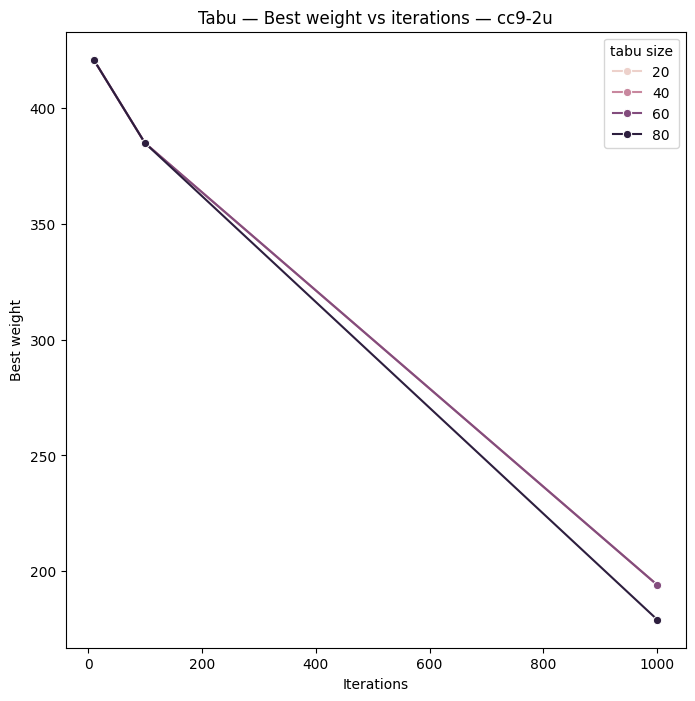

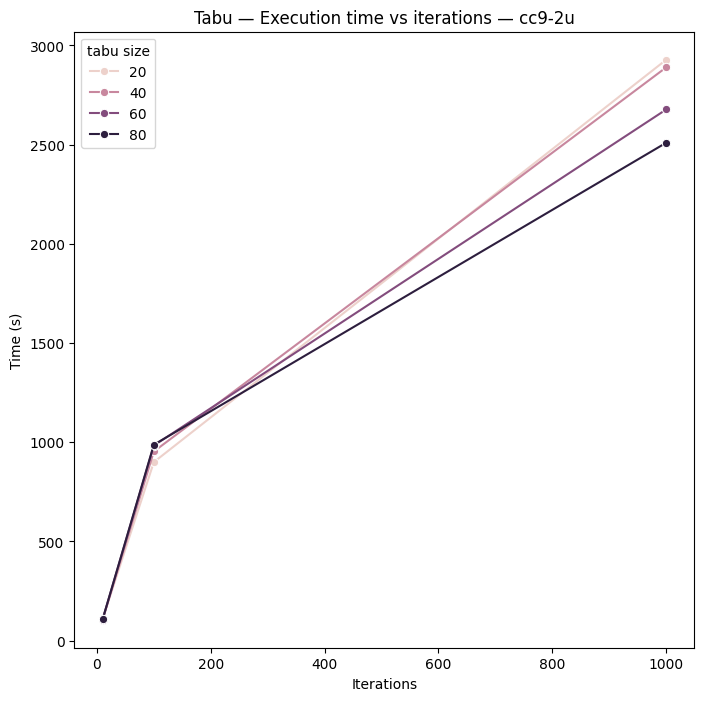

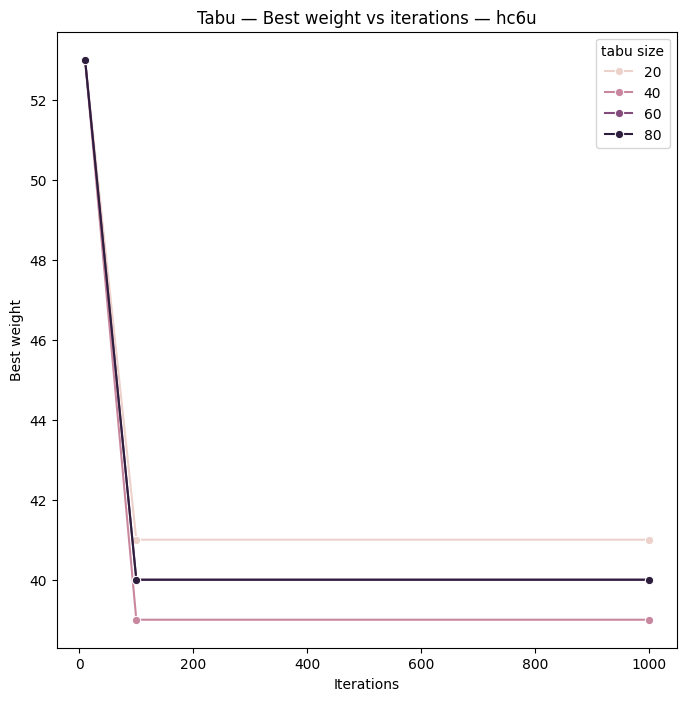

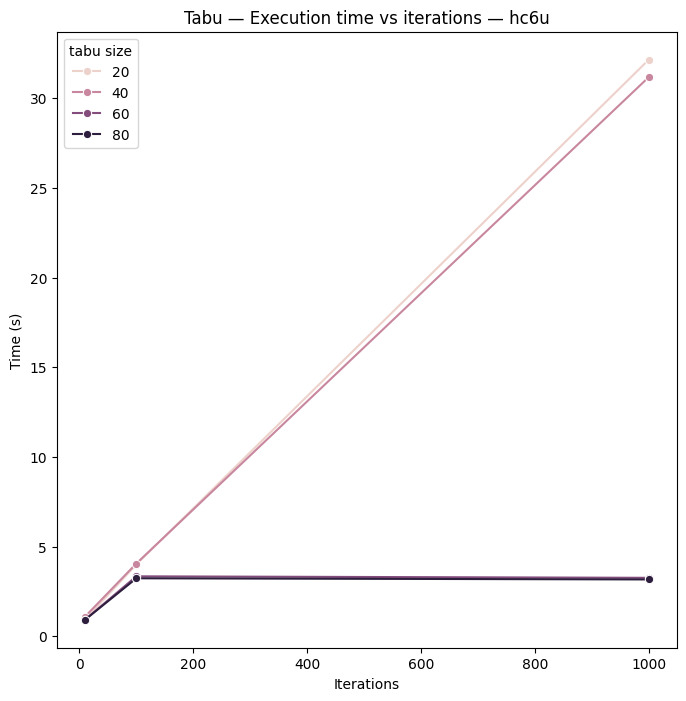

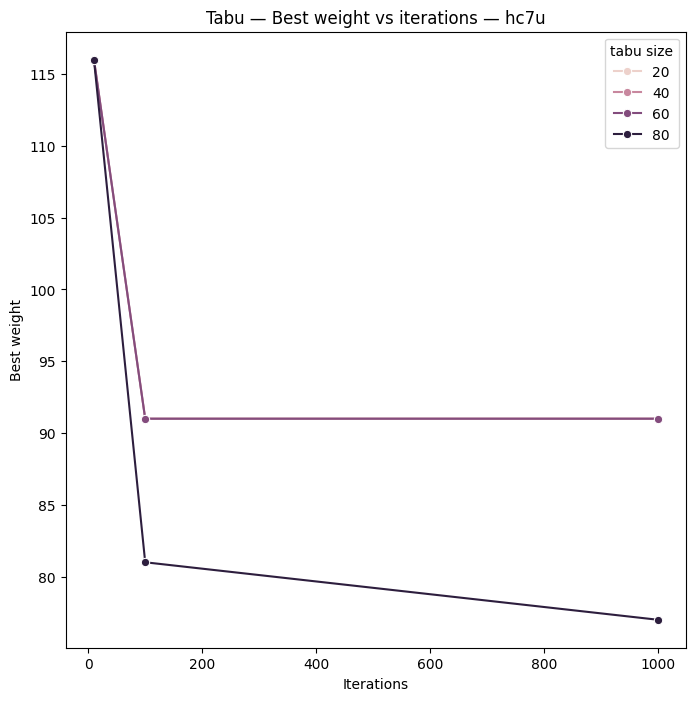

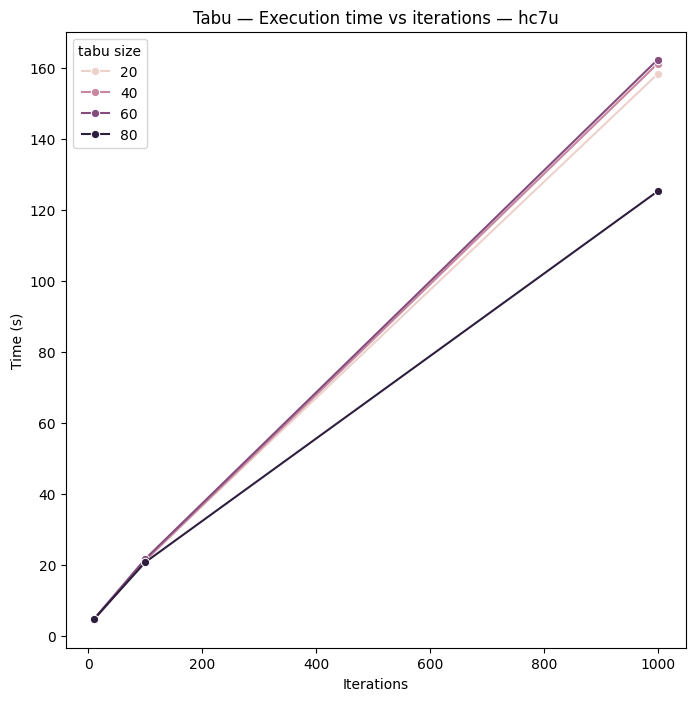

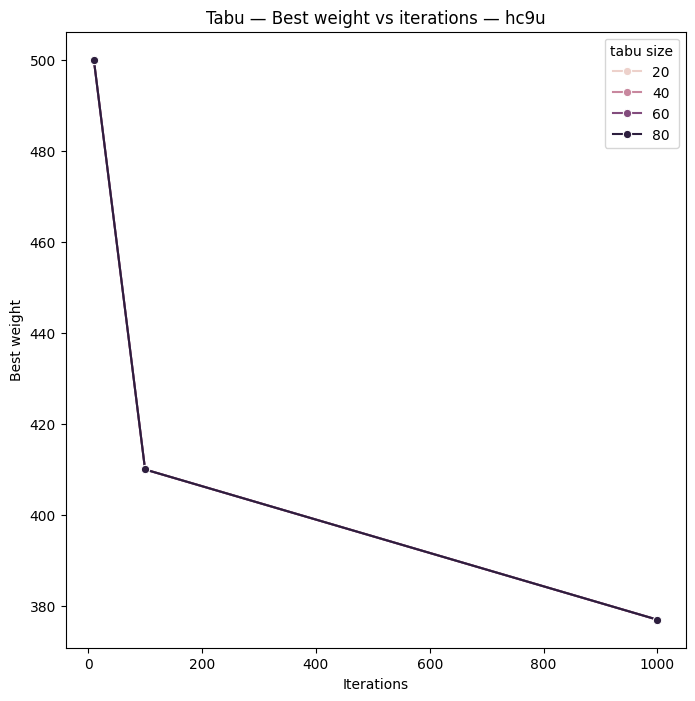

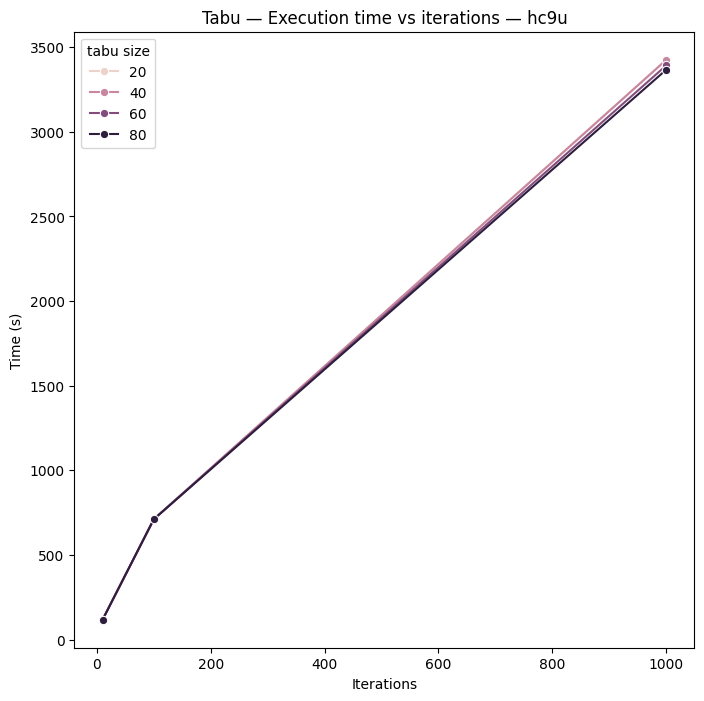

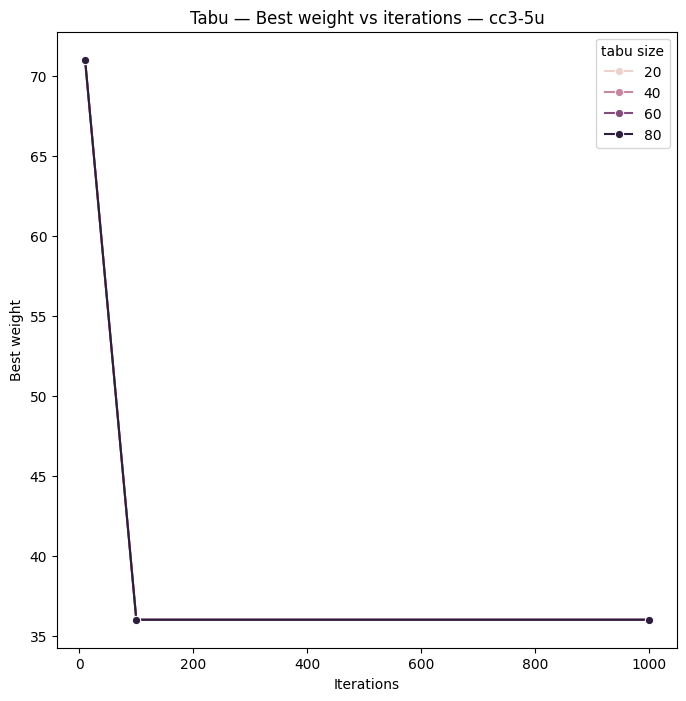

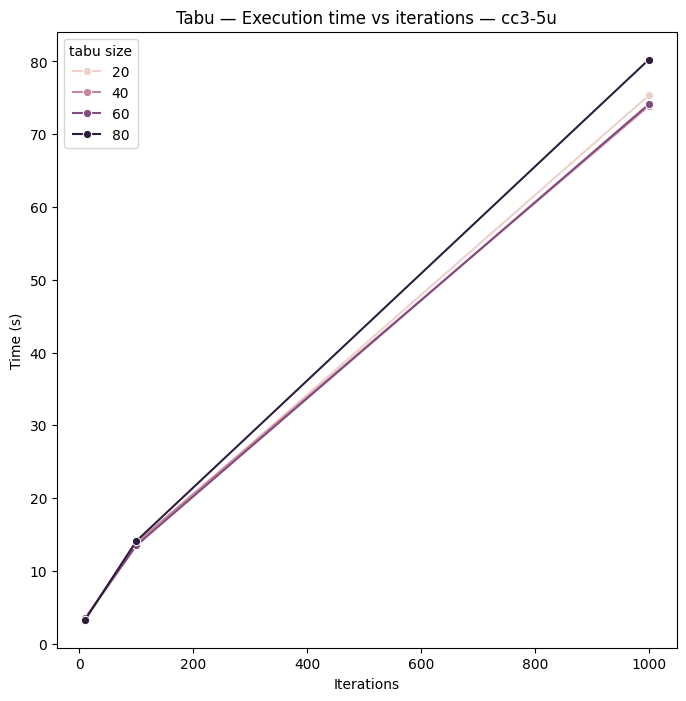

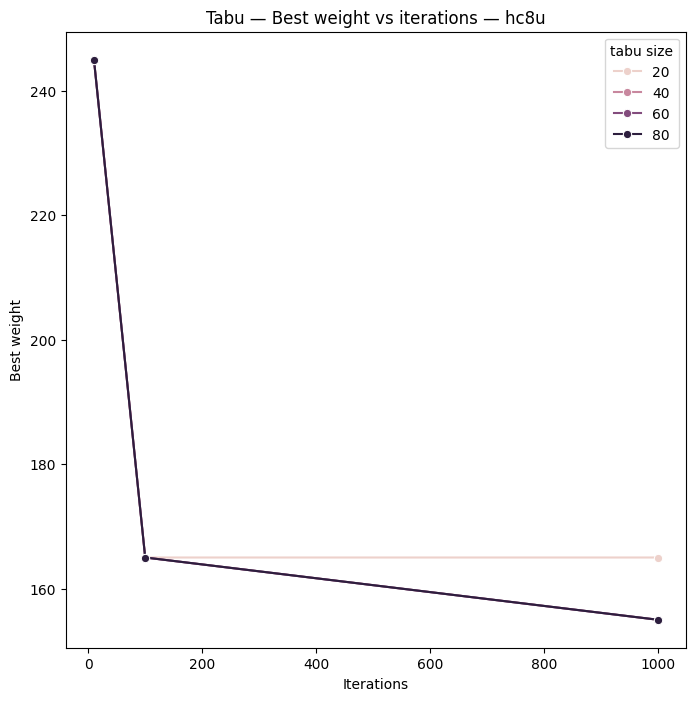

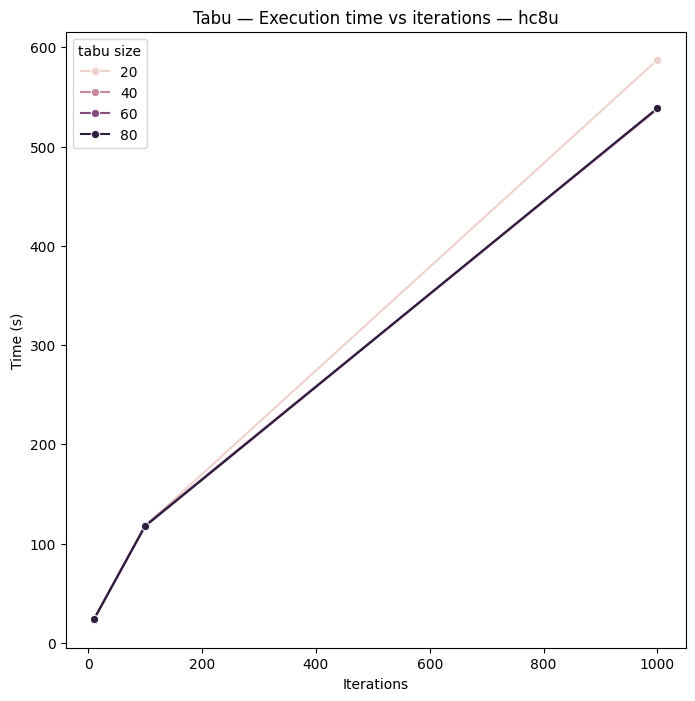

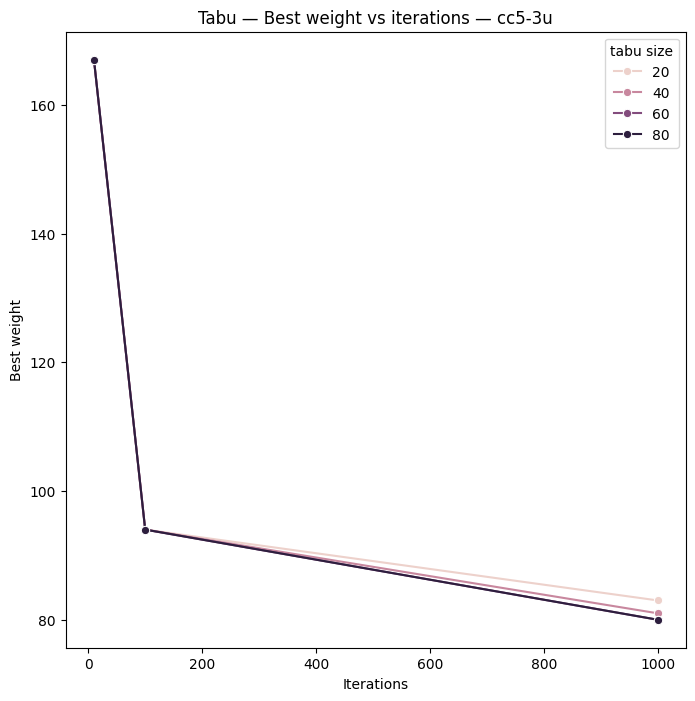

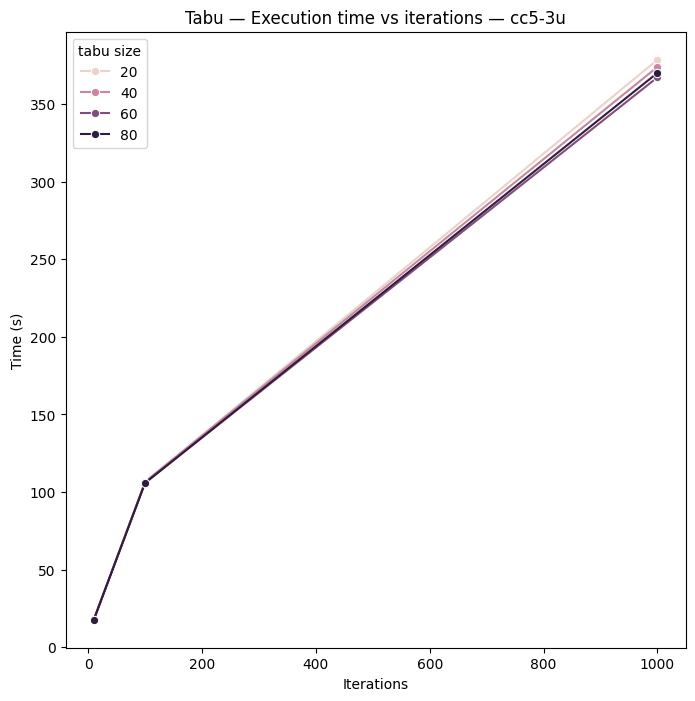

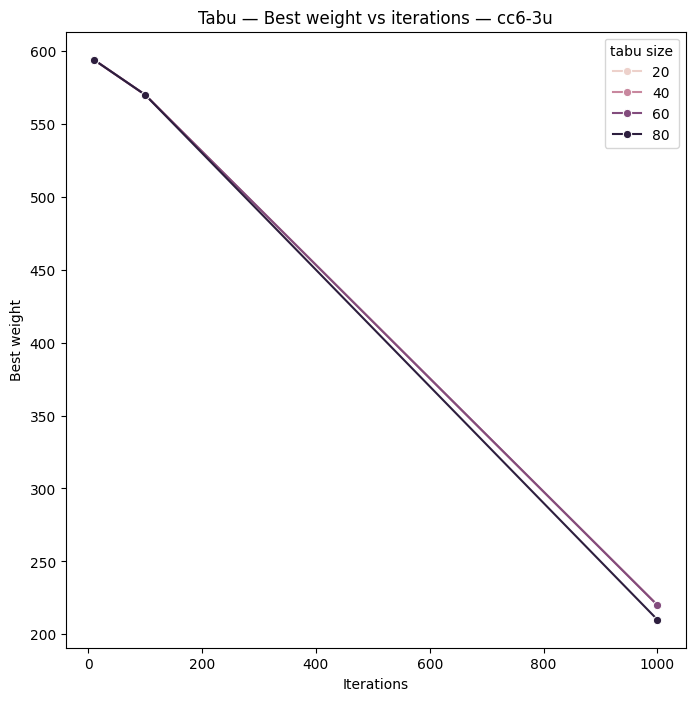

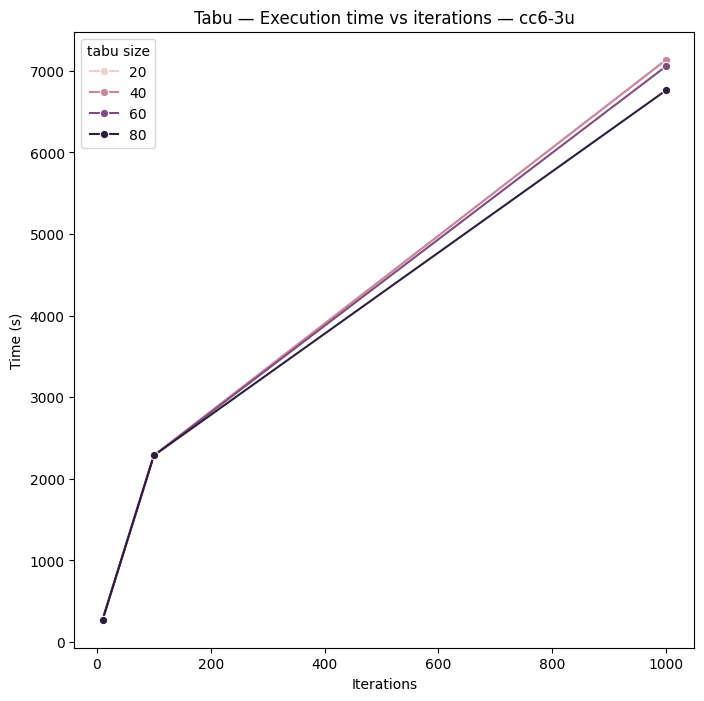

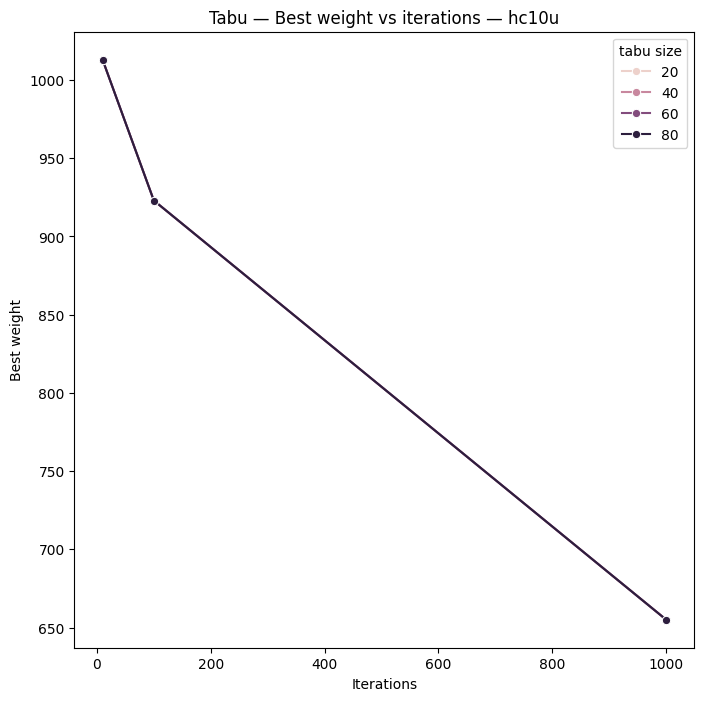

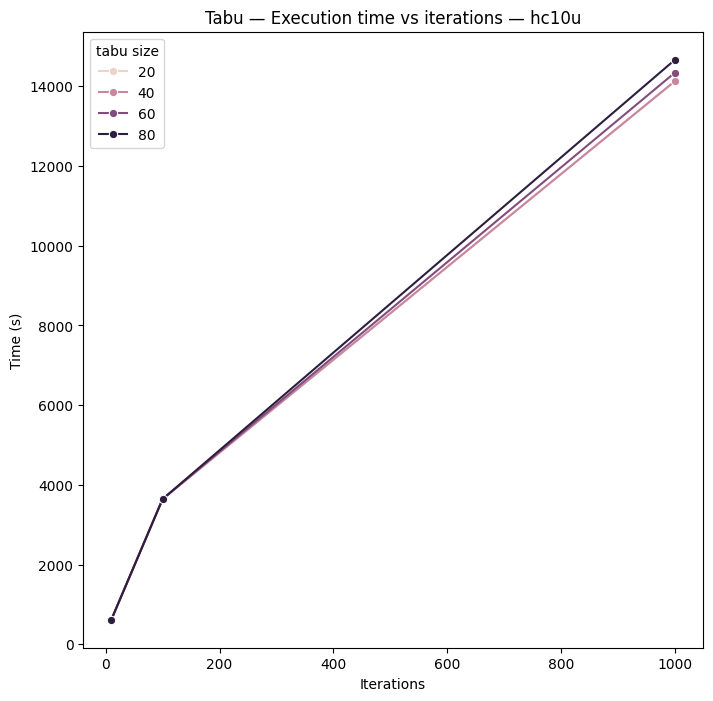

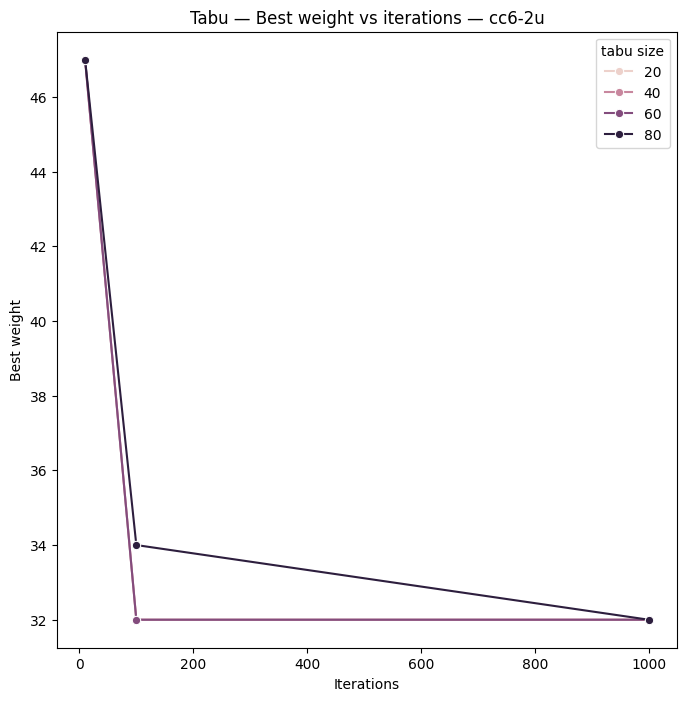

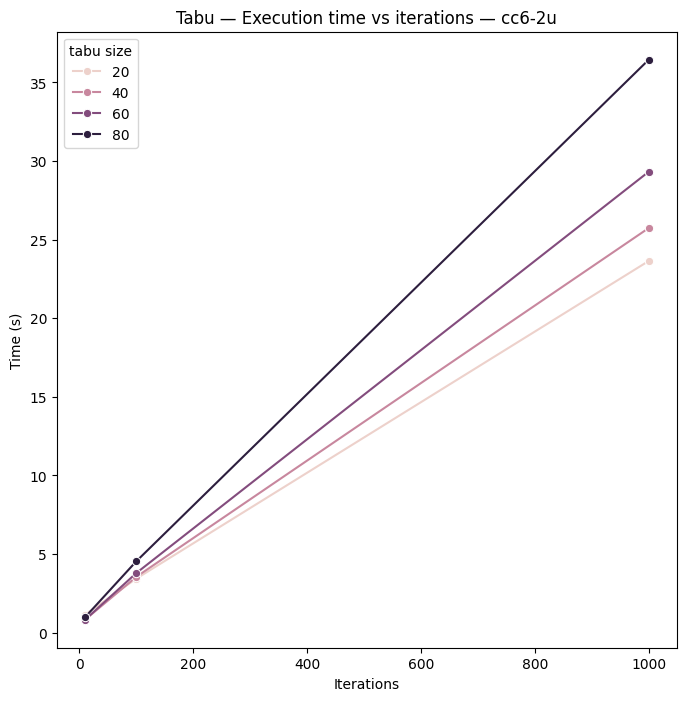

In [49]:
for g in df["graph_name"].unique():
    sub = df[df["graph_name"] == g]

    plt.figure(figsize = (8,8))
    sns.lineplot(data = sub, x = "iterations", y = "best_w", hue = "tabu size", marker = "o")
    plt.title(f"Tabu — Best weight vs iterations — {g}")
    plt.xlabel("Iterations")
    plt.ylabel("Best weight")
    plt.savefig(f"plots_tabu/{g}_bestweight.png", dpi = 300, bbox_inches = "tight")
    plt.show()
    plt.close()
    
    plt.figure(figsize = (8,8))
    sns.lineplot(data = sub, x = "iterations", y = "time", hue = "tabu size", marker = "o")
    plt.title(f"Tabu — Execution time vs iterations — {g}")
    plt.xlabel("Iterations")
    plt.ylabel("Time (s)")
    plt.savefig(f"plots_tabu/{g}_time.png", dpi = 300, bbox_inches = "tight")
    plt.show()
    plt.close()